## Importing Necessary Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,Dropout,GRU
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError

## Reading Data

In [36]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [37]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


## Data split and scaling,

In [39]:
n = len(df)
df_train = df.iloc[:int(0.8*n)]
df_test = df.iloc[int(0.8*n):]

In [40]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled['Date Time'] = pd.to_datetime(df_train_scaled['Date Time'],dayfirst=True)
df_train_scaled.set_index('Date Time',inplace=True)

df_test_scaled['Date Time'] = pd.to_datetime(df_test_scaled['Date Time'],dayfirst=True)
df_test_scaled.set_index('Date Time',inplace=True)

df_train_scaled.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [41]:
scaler = MinMaxScaler()

columns= (df_train_scaled.columns)

df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

df_train_scaled

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,0.826390,0.254629,0.248031,0.334788,0.923033,0.040985,0.084272,0.005223,0.081679,0.082798,0.743213,0.070403,0.074468,0.423056
2009-01-01 00:20:00,0.826889,0.248004,0.241495,0.326891,0.924182,0.039263,0.081003,0.004986,0.078843,0.079586,0.749349,0.049214,0.063830,0.378056
2009-01-01 00:30:00,0.826490,0.246305,0.239819,0.326268,0.929925,0.038919,0.080639,0.004748,0.078276,0.079229,0.750666,0.012987,0.026809,0.476667
2009-01-01 00:40:00,0.826291,0.249703,0.243338,0.331255,0.933372,0.039780,0.082819,0.004511,0.080545,0.081370,0.747523,0.023240,0.021277,0.550000
2009-01-01 00:50:00,0.826291,0.250382,0.243841,0.331879,0.932223,0.039952,0.083182,0.004511,0.080545,0.081727,0.746954,0.021873,0.026809,0.595278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-24 18:40:00,0.761212,0.699168,0.696330,0.715087,0.501206,0.343034,0.400291,0.215100,0.394214,0.397216,0.356401,0.097744,0.098723,0.160556
2015-05-24 18:50:00,0.761312,0.697469,0.694654,0.712386,0.499598,0.340796,0.396295,0.214387,0.390811,0.393291,0.357778,0.084074,0.080000,0.114944
2015-05-24 19:00:00,0.761411,0.695431,0.692643,0.711554,0.502929,0.338040,0.395568,0.211538,0.389677,0.392220,0.359334,0.107997,0.091915,0.095472


In [42]:
df_test_scaled

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2015-05-24 19:30:00,0.761013,0.687447,0.684766,0.717581,0.535669,0.327708,0.403560,0.191833,0.397618,0.400428,0.364572,0.118934,0.090213,0.091500
2015-05-24 19:40:00,0.760116,0.685748,0.683258,0.717373,0.539345,0.325469,0.403197,0.188984,0.397618,0.400071,0.365500,0.103213,0.085106,0.063083
2015-05-24 19:50:00,0.759916,0.682181,0.679739,0.717581,0.549225,0.320992,0.403560,0.182574,0.397618,0.400785,0.367955,0.036910,0.069787,0.031556
2015-05-24 20:00:00,0.760016,0.678274,0.675884,0.717581,0.559449,0.316170,0.403560,0.175689,0.397618,0.400785,0.370798,0.015721,0.025532,0.058028
2015-05-24 20:10:00,0.760215,0.674367,0.671862,0.719244,0.573693,0.311348,0.406102,0.167616,0.399887,0.402926,0.373582,0.046480,0.046809,0.071861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,0.861770,0.322066,0.310039,0.350790,0.690982,0.061478,0.091173,0.028965,0.088486,0.089222,0.699003,0.045796,0.064681,0.666667
2016-12-31 23:30:00,0.860375,0.333956,0.321937,0.352244,0.652039,0.065783,0.091900,0.034188,0.089053,0.089936,0.688407,0.077922,0.081702,0.650833
2016-12-31 23:40:00,0.859278,0.337184,0.325289,0.349127,0.631361,0.066988,0.090447,0.036800,0.087918,0.088508,0.685264,0.073821,0.085106,0.597778


## Splitting features and Target, As well as Creating Sequence to train LSTM on

In [43]:
X_feat = df_train_scaled.drop(columns=['T (degC)'])
y_feat = df_train_scaled['T (degC)']

In [44]:
df_train_scaled = np.array(df_train_scaled)
df_test_scaled = np.array(df_test_scaled)

X=[]
y=[]
n_future = 1
n_past = 10

for i in range(n_past,len(df_train_scaled)-n_future+1):
  feat = np.concatenate(
      (df_train_scaled[i-n_past:i,[0]],df_train_scaled[i-n_past:i,2:df_train_scaled.shape[1]]),
      axis=1
  )
  X.append(feat)
  y.append(df_train_scaled[i+n_future-1:i+n_future,1])

X_train,y_train = np.array(X),np.array(y)

X=[]
y=[]
for i in range(n_past,len(df_test_scaled)-n_future+1):
  feat = np.concatenate(
      (df_test_scaled[i-n_past:i,[0]],df_test_scaled[i-n_past:i,2:df_test_scaled.shape[1]]),
      axis=1
  )
  X.append(feat)
  y.append(df_test_scaled[i+n_future-1:i+n_future,1])

X_test,y_test = np.array(X),np.array(y)

In [45]:
print('X_train shape : {}   y_train shape : {} \n'
      'X_test shape : {}      y_test shape : {} '.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train shape : (336430, 10, 13)   y_train shape : (336430, 1) 
X_test shape : (84101, 10, 13)      y_test shape : (84101, 1) 


## Training Model

In [49]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(y_train.shape[1]))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
result = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/10
9463/9463 ━━━━━━━━━━━━━━━━━━━━ 63s 7ms/step - loss: 1.5771e-05 - root_mean_squared_error: 0.0040 - val_loss: 1.5955e-05 - val_root_mean_squared_error: 0.0040
Epoch 2/10
9463/9463 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 1.5622e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.6187e-05 - val_root_mean_squared_error: 0.0040
Epoch 3/10
9463/9463 ━━━━━━━━━━━━━━━━━━━━ 62s 7ms/step - loss: 1.5589e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.6330e-05 - val_root_mean_squared_error: 0.0040
Epoch 4/10
9463/9463 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - loss: 1.5530e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.6417e-05 - val_root_mean_squared_error: 0.0041
Epoch 5/10
9463/9463 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - loss: 1.5460e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.6462e-05 - val_root_mean_squared_error: 0.0041
Epoch 6/10
9463/9463 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 1.5385e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.6482e-05 - val_root_mean_squared_

In [59]:
best_model = load_model('best_model.h5', custom_objects={'mse': mse})

## Plot (Train and Val lossvariation across epochs ,Predicted and True Values)

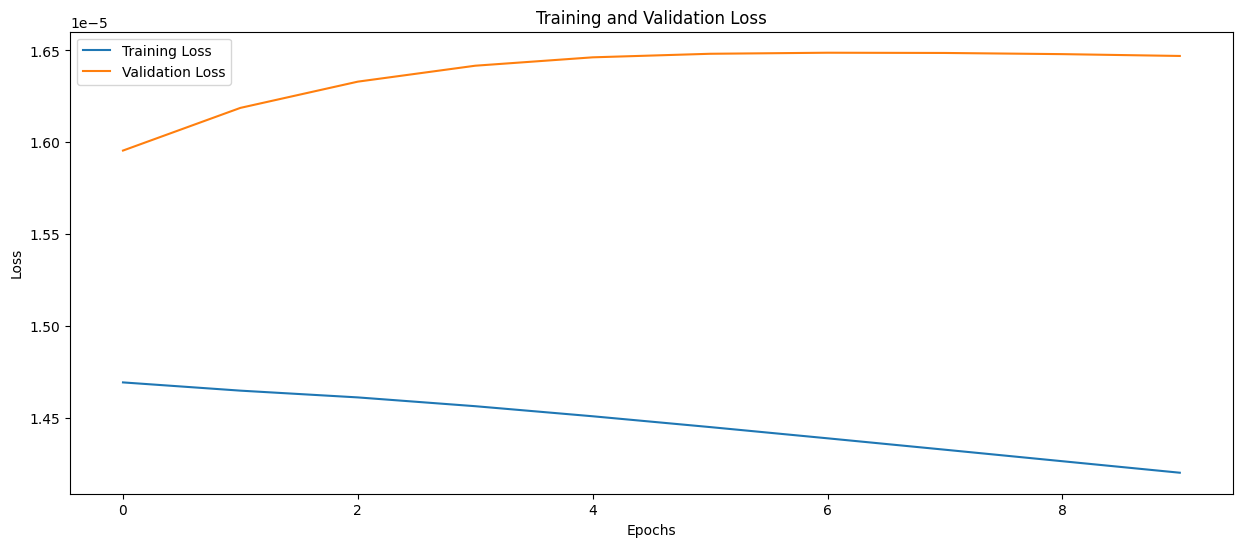

In [56]:
plt.figure(figsize=(15,6))
plt.plot(result.history['loss'], label='Training Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results.head()

2629/2629 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


,Train Predictions,Actual
0,0.657518,0.660438
1,0.658841,0.659589
2,0.657133,0.655852
3,0.652525,0.652964
4,0.650829,0.649057


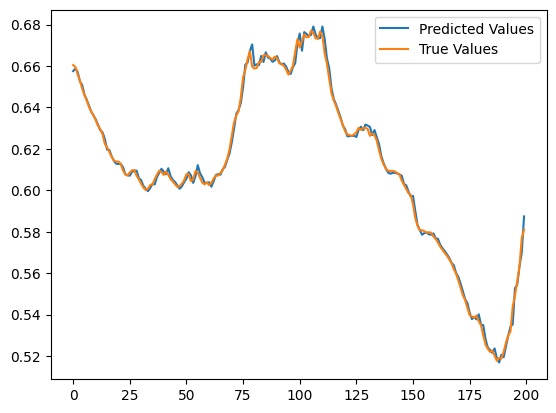

In [58]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()